In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import index_haps as idh

In [2]:
sourcefile = '../Data/Amp_data/allele_counts_anon.tsv'
metadata = '../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx'
pt_id = 'PD7153'
plate = idh.data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate1_PD7153 = idh.calc_scVAF_mod(plate, pt_id, reads)

PD7153
Cells with 10 reads for amplicon PD7153_SRSF2  =  1325
Mono 322
Neut 165
nBC 21
CD34 817
Cells with 10 reads for amplicon PD7153_TET2a  =  2158
Mono 548
Neut 614
nBC 59
CD34 937
Cells with 10 reads for amplicon PD7153_TET2b  =  1957
Mono 555
Neut 468
nBC 22
CD34 912
{'PD7153_TET2b': 0, 'PD7153_SRSF2': 1, 'PD7153_TET2a': 2}


In [3]:
data = plate.copy()
reads = 10

cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Group the data and calculate total reads and mutant frquency
df = data.copy()

df = df.loc[df['Amplicon'].isin(cols)]
df = df.groupby(['Plate', 'Well','Amplicon', 'Genotype']).sum().unstack()
df.columns = ['MT', 'WT']
df['Total'] = df['MT'] + df['WT']
df['Mut_freq'] = df['MT']/df['Total']

df['Amplicon'] = df.index.get_level_values(2)
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
df['Sort_cell_type'] = df['Plate'].replace(plate_cell_dict)
rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34', 'NEs':'Neut', 'Monocytes': 'Mono', 'nBCs': 'nBC'}
df['Sort_cell_type'].replace(rename, inplace = True) #df now contains cell type as well
dfcells = df['Sort_cell_type'].drop_duplicates().to_list()

In [4]:
nbc = df.loc[(df['Sort_cell_type'].isin(['nBC'])) & (df['Total'] >= 10) & (df['Amplicon'].isin(['PD7153_SRSF2']))]
nbc_wells = nbc['Plate_Well'].drop_duplicates().to_list()
print('Total cells, nBC = ', len(nbc_wells))
print('Total reads, nBC = ', nbc['Total'].sum())
print('Total MT reads, nBC = ', nbc['MT'].sum())

Total cells, nBC =  21
Total reads, nBC =  741.0
Total MT reads, nBC =  22.0


In [5]:
mono = df.loc[(df['Sort_cell_type'].isin(['Mono'])) & (df['Total'] >= 10) & (df['Amplicon'].isin(['PD7153_SRSF2']))]
mono_wells = mono['Plate_Well'].drop_duplicates().to_list()
print('Total cells, Mono = ', len(mono_wells))
print('Total reads, Mono = ', mono['Total'].sum())
print('Total MT reads, Mono = ', mono['MT'].sum())

Total cells, Mono =  322
Total reads, Mono =  22189.0
Total MT reads, Mono =  9290.0


In [6]:
cd34 = df.loc[(df['Sort_cell_type'].isin(['CD34'])) & (df['Total'] >= 10) & (df['Amplicon'].isin(['PD7153_SRSF2']))]
cd34_wells = cd34['Plate_Well'].drop_duplicates().to_list()
print('Total cells, CD34 = ', len(cd34_wells))
print('Total reads, CD34 = ', cd34['Total'].sum())
print('Total MT reads, CD34 = ', cd34['MT'].sum())

Total cells, CD34 =  817
Total reads, CD34 =  156920.0
Total MT reads, CD34 =  64113.0


In [8]:
dict3 = {}

for j, c in enumerate(cols): #cols contains amplicon names

    #Work out which wells fit the read criteria, and how many cells there are of each type
    df1 = df.loc[(df['Amplicon'] == c) & (df['Total'] >= reads)]
    dict2 = {}
    
    #look at each cell type in turn
    for k, dfc in enumerate(dfcells):
        df2 = df1.loc[df1['Sort_cell_type'].isin([dfc])]
        vals = df2['Mut_freq'].values #put mut frquencies into a np array
        rng = np.random.default_rng()  
        dict1 = {}
        
        r = np.arange(10, 101, 10)
        for n in r:
            d = []
            for i in range(50): #number of iterations
                rng.shuffle(vals)
                d.append(vals[:n].mean()) #sample more cells in each iteration

            dict1[n] = d

        
        dict2[dfc] = dict1
    dict3[c] = dict2
        
dist = pd.DataFrame.from_dict({(i,j): dict3[i][j] 
                           for i in dict3.keys() 
                           for j in dict3[i].keys()},
                       orient='index')
dist_df = dist.stack().to_frame()
dist_df.columns = ['means']
dist_df = dist_df.reset_index()
dist_df.columns = ['Amplicon', 'Celltype', 'Subsample', 'means']

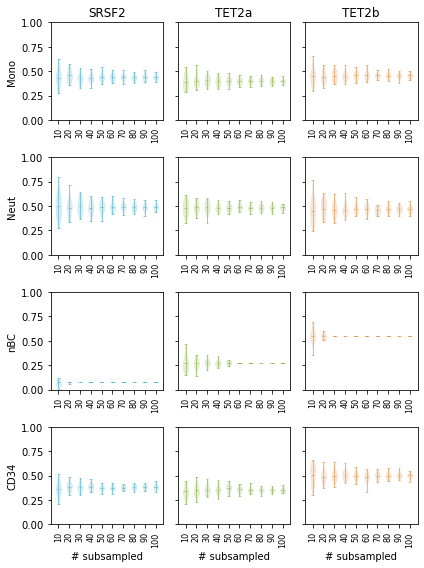

In [10]:
fig, ax = plt.subplots(4,3, figsize = (6, 8), sharey = True)
ax = ax.ravel()

color = {'PD7153_TET2b': (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 'PD7153_TET2a': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 'PD7153_SRSF2': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209)}

for i, dfc in enumerate(dfcells):
    data = dist_df.copy()
    data1 = data.loc[data['Celltype'].isin([dfc])]
    for j, c in enumerate(cols):
        data2 = data1.loc[data1['Amplicon'].isin([c])]
        m = (i*3) + j
        dat = {}
        for n, k in enumerate(np.arange(10, 101, 10)):
            l = m*10 + n
            data3 = data2.loc[data2['Subsample'].isin([k])]
            dat[k] = data3['means'].to_list()
            
        d = [dat[10][0],
            dat[20][0],
            dat[30][0],
            dat[40][0],
            dat[50][0],
            dat[60][0],
            dat[70][0],
            dat[80][0],
            dat[90][0],
            dat[100][0],]
        
        violin_parts = ax[m].violinplot(d, showmeans=True)
        
        for partname in ('cbars','cmins','cmaxes','cmeans'):
            vp = violin_parts[partname]
            vp.set_edgecolor(color[c])
            vp.set_linewidth(0.5)

        for vp in violin_parts['bodies']:
            vp.set_facecolor(color[c])
            vp.set_edgecolor(color[c])
            vp.set_linewidth(0.5)
            vp.set_alpha(0.2)

        ax[m].set_ylim(0, 1)
        ax[m].set_xticks(np.arange(1, 11))
        ax[m].set_xticklabels(np.arange(10, 101, 10), rotation = 90, fontsize = 8)
        
        if m in [0, 3, 6, 9]:
            ax[m].set_ylabel(dfc)
            
        if m in [0, 1, 2]:
            ax[m].set_title(c.split('_')[1])
            
        if m in [9, 10, 11]:
            ax[m].set_xlabel('# subsampled')
            
        
            
fig.tight_layout()
fig.savefig('../Results/subsampleVAFS.svg',bbox_inches='tight', dpi = 600)
fig.savefig('../Results/subsampleVAFS.png',bbox_inches='tight', dpi = 600)